# Dimensionality Reduction

By Laxman Singh Tomar

In this tutorial, I'll analyze and cover the workflow of popular Dimensionality Reduction Techniques viz. **Principal Component Analysis** aka **(PCA)** and **Singular Value Decomposition** aka **(SVD)**. I'll tell you the maths lying behind the scenes and would implement them from scratch; in order to make you see why something is the way it's. 

---

# Outline

1. Introduction of Tutorial
    - Tutorial Objective
    - Importing the Libraries
    
2. Context
 
3. Principal Component Analysis
    - 3.1  Introduction to Principal Component Analysis (PCA)
    - 3.2 PCA from Scratch
    
         - 3.2.1 Standardize
        
         - 3.2.2 Eigendecomposition - Computing Eigen Vectors and Eigen Values
         
         - 3.2.3 Choosing top K EigenVectors
          
         -  3.2.4 Projection onto the new Feature Space
   
   - 3.3 Takeaways
     
4. Singlular Value Decompostion (SVD)

    - 4.1 Introduction to SVD
    - 4.2 Interpretation of SVD
    
        - 4.2.1 Geometric Interpretation
        
        - 4.2.2 Factor Interpretation
        
   - 4.3 Worked Example Full SVD
   
   - 4.4 Relationships with PCA
   
   - 4.5 Applications
   
        - 4.5.1 Dimensionality Reduction
        - 4.5.2 Information Retrieval
        - 4.5.3 Collaborative Filtering

5. References & Acknowledgements

---

# 1. Introduction of Tutorial

## 1.1 Tutorial Objective

To understand the underlying maths behind the popular Dimensionality Reduction Techniques; and to cement the concepts in my head by implementing them from scratch.


## 1.2 Importing Libraries

In this project, I'll make use of some of the standard machine learning libraries which are available in Scikit-learn along with Numpy and Pandas for Data Analysis and Matplotlib for Data Visualization.

In [1]:
 # For data analysis
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt

# Packages from scikit-learn
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Magic functions from Jupyter
# For inline plot
%matplotlib inline

#For printing versions
%reload_ext watermark

# For  making the notebook reload external python modules
%reload_ext autoreload
%autoreload 2

# For enabling retina(high resolution) plots
%config InlineBackend.figure_format = 'retina'

%watermark -p sklearn
%watermark -v -m --iversions

sklearn 0.21.2
matplotlib 3.1.1
pandas     0.25.1
numpy      1.16.4
CPython 3.7.3
IPython 7.8.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit


---

# 2. Context

Whenever we start a data analysis problem, one of the most initial steps that we undergo is some sort of exploratory data analysis of raw data at hand. Exploring your data is a crucial step as until you have basic understanding of your data viz structure of it, it's somewhat difficult to know whether the data you've is suitable for the task we gotta perform or is something from which we can draw  any insights. In real world problems, raw data consists of many features. On one hand it's good to have multiple features as it allows our models to generalize well, but on the other it's bad as we can only work things out for visualizations upto 3 dimensions.  So how can we go on exploring our data? The answer to this problem is Dimensionality Reduction.  Dimensionality Reduction helps us out by providing a simpler and more compact representations of our original raw data to either aid our understanding or to provide useful input for the incoming stages of analysis. Here we'll focus on two such techniques one by one.

What happens is, whenever we have a problem at hand or we're trying to understand some underlying phenomenon, in order to do so we measure various quantities potentially related to it. In most cases, if we knew exactly what to measure in advance, we might be able to find some simpe relationships in our data. Say, when we have a mensuration problem, most of the time we know which formula will work things out for us. So we just try to find values which can be plugged into formula equation. But sadly, generally we aren't that fortunate and don't know what we got to measure, so we often end up measure anything that might be relevant and end up having irrelevant or redundant signals in our measurements. To make this a bit more concrete, let's try to generate a 2-dimensional dataset which works with the equation given below:

$$ x_2 = 400 + 10 *x_1 + \epsilon $$

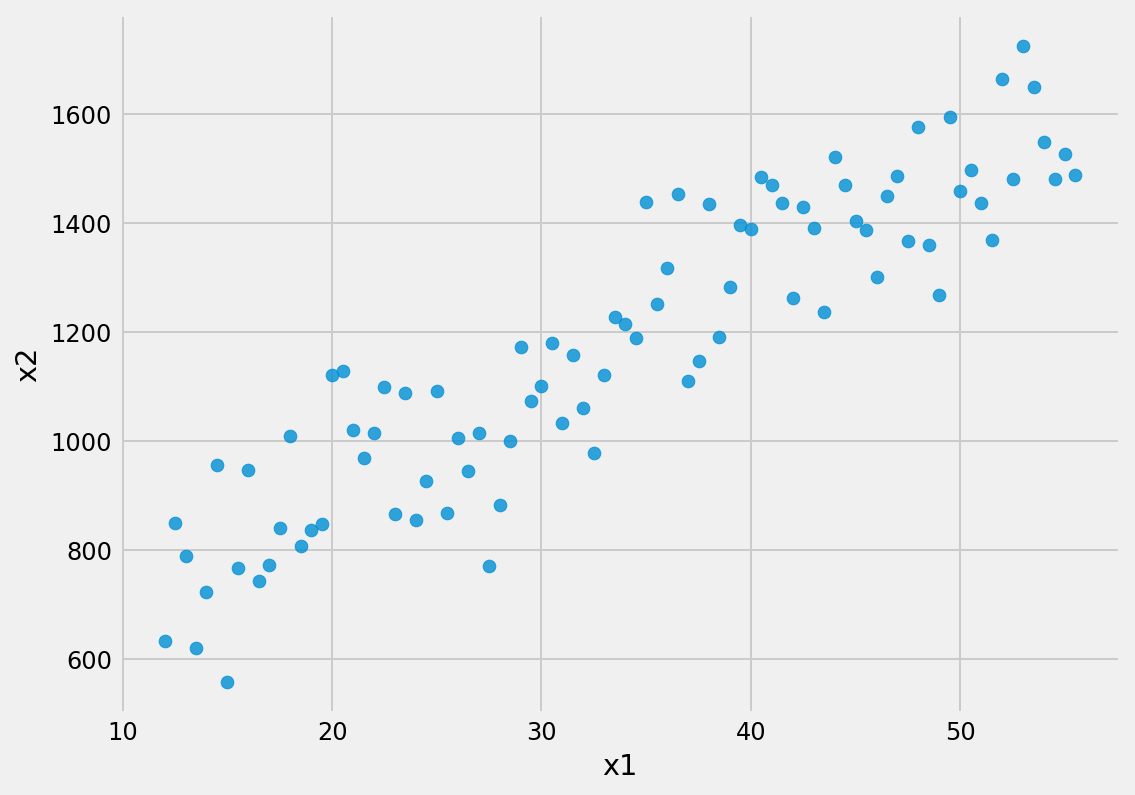

In [2]:
# Getting random values
np.random.seed(123)

# Values of x1 ranging from 12-56 with a step-size of 0.5
x1 = np.arange(12, 56, 0.5)

#Values of epsilon
e = np.random.normal(0, 100, x1.shape[0])

#Values of x2 by plugging in x1 and e
x2 = 500 + 20 * x1 + e

X = np.c_[x1, x2]

# Changing the default style figure and font size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# Creating a function for scatter plot
def plot2var(m):
    plt.scatter(m[ :, 0  ], m[ :, 1], s = 40, alpha = 0.8)
    plt.xlabel('x1')
    plt.ylabel('x2')
    
plot2var(X)

Now it's pretty evident from the plot that there's a linear relationship between the 2 variables, thus we probably don't need to include both of them as $x_1$ can be easily explained by $x_2$  and vice versa.

---

# 3. Principal Component Analysis (PCA)

## 3.1 Introduction to PCA

So, now you know that there might exist some features which may be redundant as their behavior can be explained by other features, we should be able to summarize the data with less features. So, what PCA does to solve this issue is: Instead of simply picking out the useful features and discarding the others it uses a linear combination of the existing features and constructs some new features that are better alternative representation of original data. In our 2-dimensional dataset above, PCA will try to pick the best single direction, or often referred as **first principal component** in 2D, and project our points onto that single direction. Immediately the next question arises, out of the many possible lines in 2-dimension, which line should we pick?

It turns out that, there are couple of different answers to this question. First of them would be that we're looking for some features that strongly differ across data points, thus PCA looks for features that captures as much as variation across data points as possible. Second answer would be that we're looking for the features that would allow us to *reconstruct* the original features. Imagine that we come up with a feature that has little do with the original features we had, if we were to use this new feature, there's no way we can relate this to the original features. So no point in taking this up! Hence, PCA looks for features that minimizes the reconstruction error. 

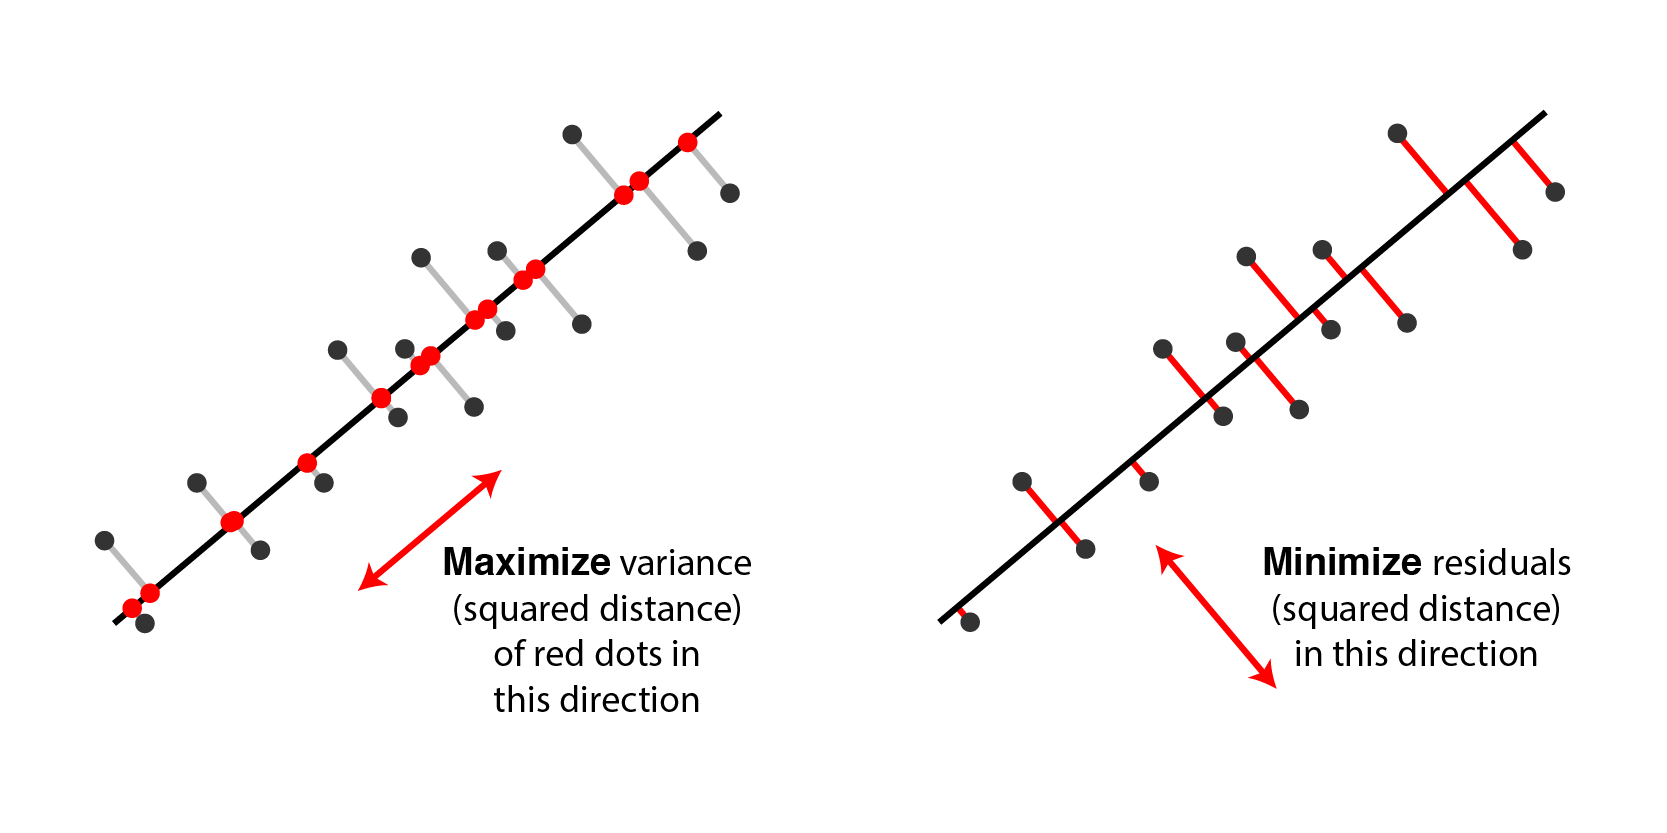

So, behavior of PCA can be explained by both these outlooks; shown in figure above. Here black dot represent original data points, black line represents the projected line, red dot on the left represents the points on the projected line and the red line represents the reconstruction error.

Suprisingly, it turns out that these 2 objectives are equivalent and PCA can do both of them simulatenously. To see, why minimizing the sum of the squared residuals is equivalent to maximizing variance consider the 2dimension visualization below:

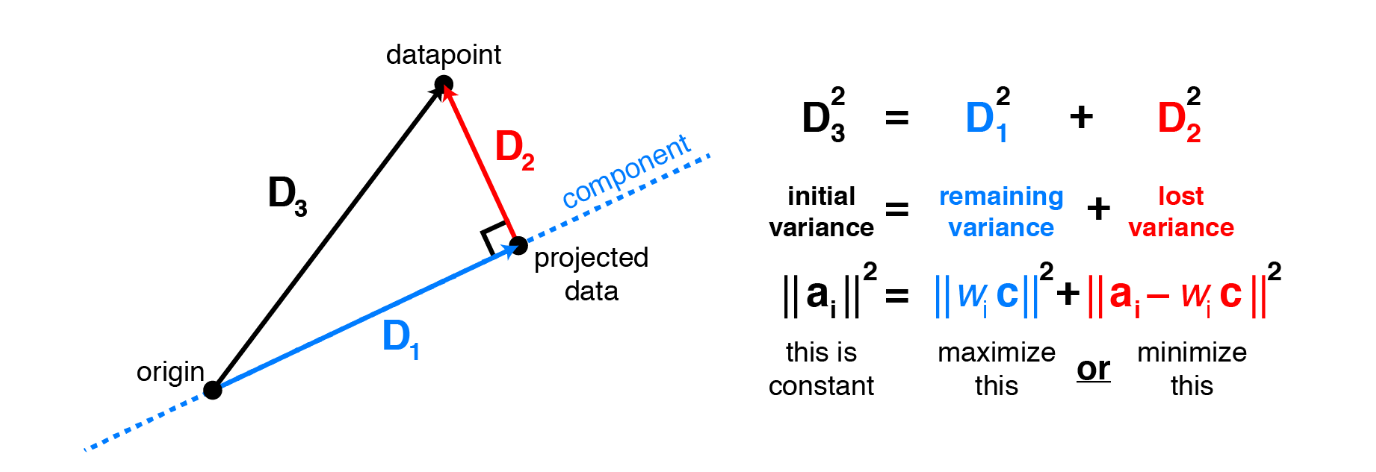

Consider a datapoint $a_i$. The contribution of this specific data point to the total variance is $a_i^T  a_i$, or equivalently the squared Euclidean length $||a_i||^2$. Applying the Pythagorean theorem shows that this total variance equals the sum of variance lost(thr squared residual) and variance remaining. Thus, it's equivalent to either maximizing remaining variance or minimizing lost variance to find the principal components.

Before delving deep into it, let's build some intuition using the Scikit-learn library. The following section standardizes the data, fits the PCA model and prints out some of the important information:

In [3]:
# Start out by standardizing our dataset
X_std = StandardScaler().fit_transform(X)

# Using PCA included in Sklearn to get only the first two principal components as we have only two variables or dimensions
pca = PCA( n_components = 2 )
pca.fit(X_std)

# Important Information
print('Components:\n', pca.components_)
print('Explained Variance Ratio:\n', pca.explained_variance_ratio_)

Components:
 [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]
Explained Variance Ratio:
 [0.95588995 0.04411005]


So lemme quickly cover what's happening here: After fitting the PCA on the dataset we generated above, the fit learns some quantities from the dat, and most importantly the *components*, which are our principal components (the new line or direction over which we will project our original data points) and *explained variance ratio*, which corresponds to the the percentage of variance explained by each of the principal component. To get a better understanding of what these numbers mean, let's visualize them over our standardized input data we made above:

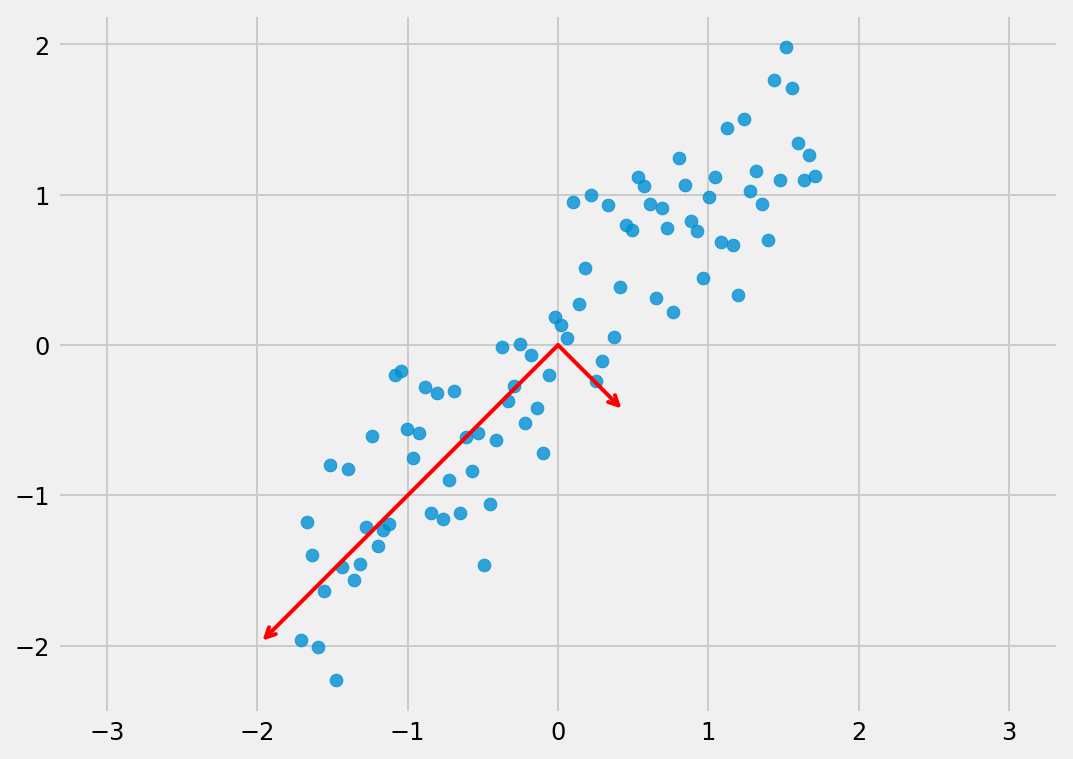

In [4]:
# Function for Visualizing the PCA

def draw_vector(v0, v1):
    #draw principal components as vectors
    ax = plt.gca()
    arrowprops = dict( arrowstyle = '->', linewidth = 2, edgecolor = 'red', shrinkA = 0, shrinkB = 0 )
    plt.annotate( '' , v1, v0, arrowprops = arrowprops )
    
# Plotting data
plt.scatter(X_std[:, 0], X_std[:, 1], s = 40, alpha = 0.8 )
for length, vector in zip(pca.explained_variance_, pca.components_):
    # Larger the explained variance, the longer will be the annotated ine
    v = vector * 2 * np.sqrt(length)
    draw_vector( pca.mean_, pca.mean_ + v )
    
plt.axis('equal')
plt.show()

It's clearly visible from the plot  that our PCA model gives two principal components(the red line) and the length of the lines indicate how important a principal component is in describing the variation of the original data. So, if we are to choose one principal component to summarize our 2d dataset or which gives better representation of our original data, it'll be the line that has the longest length(largest explained variance ratio). There are two notable points here:

- The number of principal components matches the total numbers of features. 
- The first and second principal components are orthogonal to each other.


Although practically the number of the principal components is min(variables, samples). The reason behind the above mentioned 2 points is that principal components transforms the data into a new set of dimensions, and these new dimensions have to be equal to the original amount of dimensions. And similar to what we had i.e. originally $x$ and $y$ axis, these new dimensions have to be orthogonal to each other. Okay, so far we had 2 dimensions, now let's reduce the number of dimensions to 1 by transforming our data onto the most important principal component and plot it with along original data:    

Original Shape:  (88, 2)
Transformed Shape:  (88, 1)


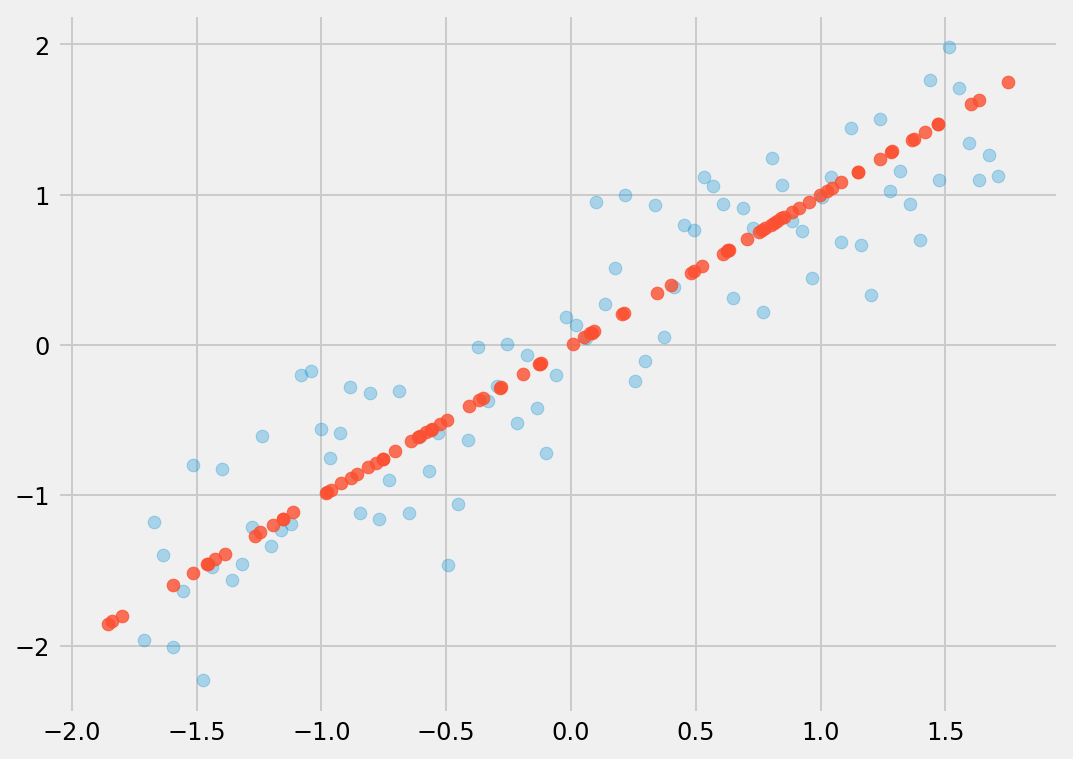

In [5]:
# Dimensionality Reduction; keeping only the first principal component
pca = PCA( n_components = 1 )
X_pca = pca.fit_transform( X_std )
print("Original Shape: ", X.shape)
print("Transformed Shape: ", X_pca.shape)

#Inverse transform to obrain the projected data points & comparing with original
X_new = pca.inverse_transform(X_pca)
plt.scatter(X_std[:, 0], X_std[:, 1], s= 40, alpha = 0.3 )
plt.scatter(X_new[:, 0 ], X_new[:, 1], s = 40, alpha = 0.8)
plt.show()

In the visualization above, the lighter points are the original data points(marked by blue color) and the darker points are the projected points(marked by red color). Upon looking at the projections, we can see that the points projected onto the first principal component all seem to be close to their initial representations & at the same time, it also captures most of the variations in our original data points.

Hopefully, this cut the clutter about what a PCA dimensionality reduction is doing. In a nutshell, PCA aims to find the directions or vectors or principal components of maximum variance in high dimensional data and project onto a smaller dimensional subspace while retaining most of the information. In our 2-dimensional example, the linear relationship between $x_1$ and $x_2$ is mostly preserved using only 1 feature instead of 2.

## 3.2 PCA from Scratch

Okay, so now we have a high-level intuitive understanding of what PCA is, and what it does. It's time now to go deep and formalize this with some notations. Recall that PCA is trying to find the direction such that the projection of the data on it(vector) has the highest variance. So given $X$, the centered data matrix, the projection, $Xw$(dot product between the data point, $X$ and the projection weight, $w$), its variance can be computed as follows:

$$\frac{1}{n-1} (X w )^T X w = w^T (\frac{1}{n-1} X^T X) w = w^T C w$$

where, $C$ is the co-variance matrix of the data $X$. In case this looks unfamiliar to you, the co-variance matrix is a $d \times d$ matrix(here d is the total number of dimensions aka features) where each element represents the co-variance between two features. The co-variance between two features $x_j$ and $x_k$ is calculated as follows:

$$\sigma_{jk} = \frac{1}{n-1} \sum\limits_{i=1}^{n}(x_ij - \bar{x}_j)(x_{ik} - \bar{x}_k)$$

where, $\bar{x}_j$ is simply the mean of the vector(feature) $\bar{x}_j = \sum\limits_{i = 1}^{n}{x_{ij}}$

We can also express the calculation of the co-variance matrix via the following matrix equation:

$$ C = \frac{1}{n-1} ((X - \bar{x})^T(X-\bar{x}))$$

As we've been assuming beforehand, that data point X has been centered, thus the $X - \bar{x}$ part can be simplified into just $X$. And the formula that we've written above now becomes:


$$C = \frac{1}{n-1} X^T X$$

Okay now that it's done, next, apart from the original function $w^T C w$ we also introduced an additional constraint $||w|| = w^Tw = 1$, which basically means that weight vector should be of unit length. The intuition behind this is: if we were to simplt maximize the formula $w^T C w$, we can multiply $w$ by any number and the objective function will increase by the square of the number. So the problem becomes ill-defined since the maximum of this expression is infinite. Given these two pieces of information, our objective function for PCA becomes:

\begin{align}
&  \underset{w}{\text{maximize}}
&&  w^T {Cw} \nonumber \\
&  \text{subject to}
&& w^T w=1
\end{align}

The objective function can be solved by the Langrage Multiplier, minimizing the loss function:

$$L = w^T Cw - \lambda (w^Tw - 1)$$

Again if this looks unfamiliar to you, you can always check out tutorials on Langrage Multiplier & how to solve them. Okay, now, to solve for $w$,  we set the partial derivative of $L$ with respect to $w$ to 0.


$$\frac{\partial L}{\partial w} = C w - \lambda{w} = 0$$

$$ = Cw = \lambda w$$

Hopefully, I'm counting on you guys, this formula looks familiar to you since it's essentially an eigen-decomposition problem. The notion of eigen-decomposition is basically trying to solve the equation:

$$Ax = \lambda x$$

Okay, in our case, $A$ is our co-variance matrix corresponding to $C$; $x$ is our eigen vector, corresponding to $w$ and $\lambda$ is our eigen value corresponding to explained variance. After solving the equation above, we'll obtain eigen vector and eigen value pairs, where every eigen vector has a corresponding eigen value. An eigen vector is essentially the direction of each principal component & the eigen value is a number telling us how much variance there is in data in that direction, in other words, how spread out the data on the line(vector). For those who want to have a quick refresher,  I'll recommend to go through how eigen values and eigen vectors are computed from scratch.

Now, as we've understood quite a lot of math stuff, let's see how all of this translates to code. Just to make things clear, the general methodology or framework for computing PCA is as follows:

- Standardize the Data.


- Obtain the Eigen vectors and Eigen values from  the co-variance matrix(precisely the correlation matrix after standardization).


- Sort Eigen values in descending order and choose the $k$ Eigen vectors that correspond to the $k$ largest Eigen values where $k$ is the number of dimensions or features of the new feature subspace.


- Projection onto the new feature space. During this step, we'll take the top $k$ eigen vectors and use it to transform the original dataset $X$ to obtain a $k$-dimensional feature subspace $X'$

For a better understanding, we will make use of famous "Iris" dataset. The Iris dataset is a 150 x 4 matrix where the columns are different features  of the flowers(sepal length in cms, sepal width in cms, petal width in cms) and every row represents a separate flower sample. The three classes in which flowers are classified are: Iris-setosa(n = 50), Iris-versicolor(n = 50), Iris-virginica(n=50). We'll use histograms to which will make things a bit clearer to understand like how the 3 different flower classes are distributed among the 4 features:

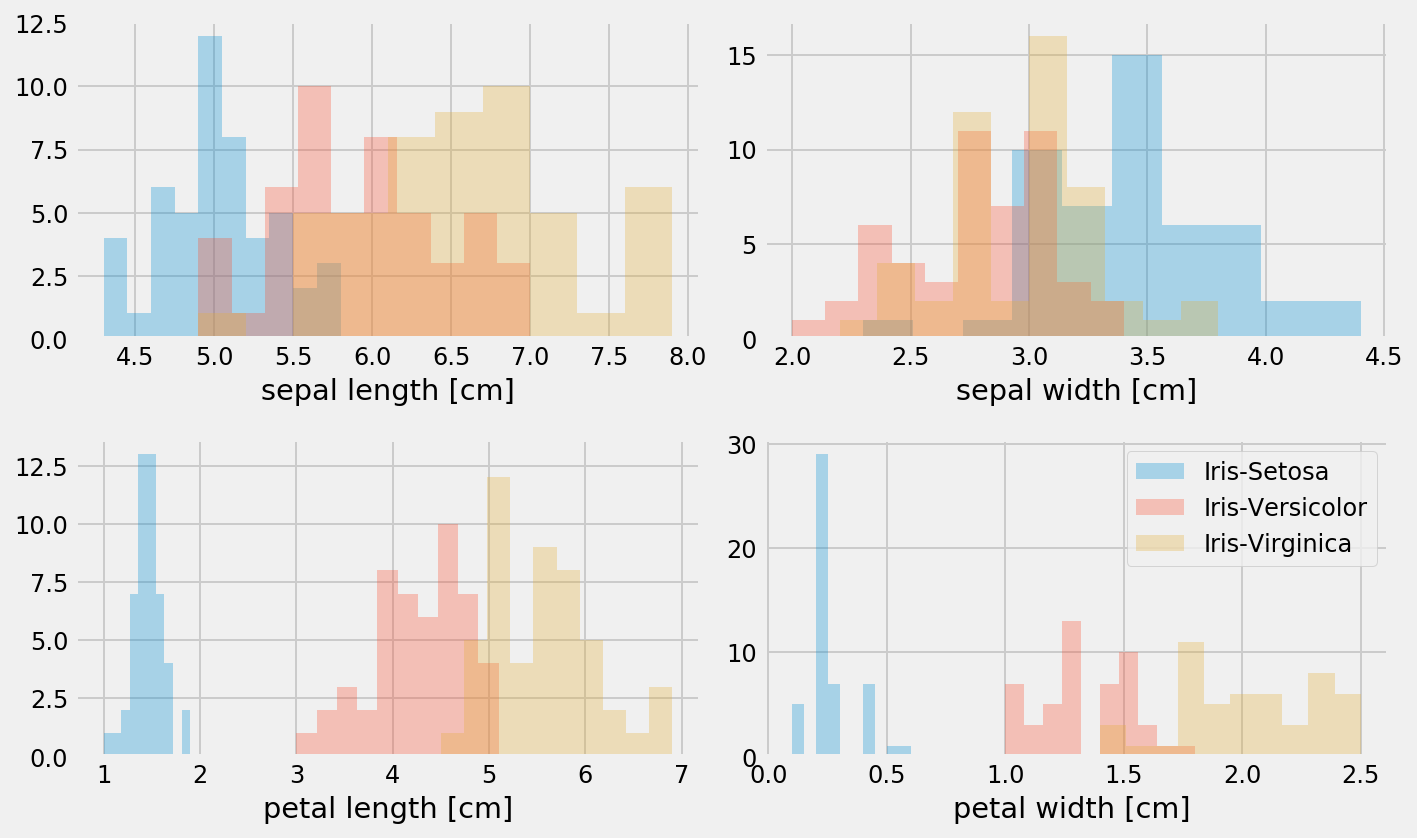

In [6]:
iris = load_iris()
X = iris['data']
y = iris['target']

label_dict = {
    0 : 'Iris-Setosa',
    1 : 'Iris-Versicolor',
    2 : 'Iris-Virginica'
}

feature_dict = {
    0 : 'sepal length [cm]',
    1 : 'sepal width [cm]',
    2 : 'petal length [cm]',
    3 : 'petal width [cm] '
}

fig = plt.figure(figsize  = (10, 6))
for feature in range(len(feature_dict)):
    plt.subplot(2, 2, feature+1)
    for index, label in label_dict.items():
        plt.hist(X[y == index, feature], label = label, bins = 10, alpha = 0.3)
        plt.xlabel(feature_dict[feature])
        
plt.legend(loc = 'upper right', fancybox = True, fontsize  = 12)
plt.tight_layout()
plt.show()

### 3.2.1 Standardize

In general, it's crucial to standardize the data prior to a PCA on the co-variance matrix depends on the measurement scales of the original ffeatures. As PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially when it was measured on different scales so different features will have equal contribution in terms of their scales.

In [7]:
# Subtract the Mean and divide the standard deviation of each features

mean = np.mean(X, axis = 0)
scale = np.std(X, axis = 0)
X_std = (X - mean) / scale

### 3.2.2 Eigen-decomposition: Computing Eigen-vectors & Eigen-values

The core of the PCA is :eigen vectors and eigen values of a co-variance matrix. The eigen-vectors(principal components) determine the directions of the new feature space, and the eigen values determine their magnitude(variance explained along the principal components):

In [8]:
# For those who're unfamiliar with the @ syntax it is equivalent of . (dot), the dot product!

vec_mean = np.mean(X_std, axis = 0)
vec_diff = X_std - vec_mean
cov_mat = vec_diff.T @ vec_diff / (X_std.shape[0] - 1)
print('Covariance Matrix \n{}'.format(cov_mat))

# One thing to keep in mind is that since we already standardized data, that means the mean vector for each features,
# vec_mean will  be 0 (really small numbers if you were to print them out), hence we don't need to subtract the mean
# to standardize them

cov_mat = X_std.T @ X_std / (X_std.shape[0] - 1)
print('\nCovariance matrix \n{}'.format(cov_mat))

# Equivalently, we can use the np.conv function: since each row represents a variable for np.conv, we'll need the covariance matrix
print('\nNumpy Covariance Matrix: \n {}'.format(np.cov(X_std.T)))

Covariance Matrix 
[[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]

Covariance matrix 
[[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]

Numpy Covariance Matrix: 
 [[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]


Okay, once you have the covariance matrix, we perform an eigen decomposition on covariance matrix to obtain the eigen values and eigen vectors.


In [9]:
# Calculating it by hand would be a tedious task, so I'll simply use the pre-implemented function 

eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigen Vectors \n%s'% eig_vecs)
print('\nEigen Values \n%s'% eig_vals)

Eigen Vectors 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]

Eigen Values 
[2.93808505 0.9201649  0.14774182 0.02085386]


### 3.2.3 Choosing Top K Eigen Vectors

Recall that, the objective of PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller feature subspace. In order to decide, which Eigen Vector(s) can be dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigen values. The idea is: eigen vectors with the lowest eigen values bear the least information about the distribution of the data and those are the ones  that can be dropped. In order to do so, the common approach is to rank the eigen values from highest to lowest in order to choose top $k$ eigen vectors.

After sorting the eigen pairs, the next question which comes to our mind is : "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called **explained variance** which can be calculated from the eigen values. The explained variance tells us how much extra information(variance) does each of the principal components contribute!

Variance Explained:  [0.72962445 0.22850762 0.03668922 0.00517871]

Cumulative Variance Expalained:  [0.72962445 0.95813207 0.99482129 1.        ]


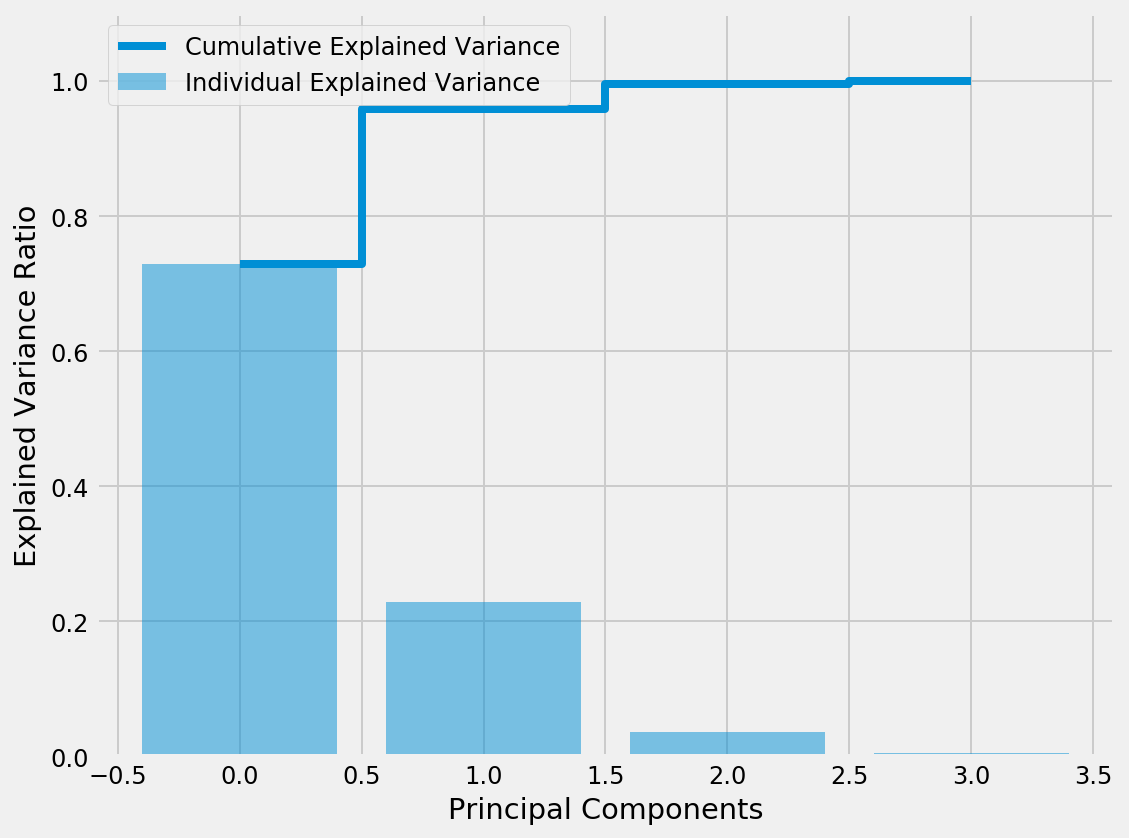

In [10]:
eig_vals_total = np.sum(eig_vals)
var_exp = eig_vals / eig_vals_total
cum_var_exp = np.cumsum(var_exp)
print('Variance Explained: ', var_exp)
print('\nCumulative Variance Expalained: ', cum_var_exp)

plt.bar(range(var_exp.shape[0]), var_exp, alpha = 0.5, align = 'center', label = 'Individual Explained Variance')

plt.step(range(var_exp.shape[0]), cum_var_exp, where = 'mid', label = 'Cumulative Explained Variance')
        
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.ylim(0, 1.1)
plt.legend(loc = 'best')
plt.tight_layout()

The plot that we've just created clearly shows that most of the variance(72.77% of the total variance to be precise) can be explained by the first principal component alone. The second principal component still bears significant information(23.03% of the total variance) while the third and fourth principal components can be safely dropped without losing too much information(as their aggregated account is not too much). Together, first and second principal components explains 95.8% of the total variance. In other lingo, it contains 95.8% of the total information (95% or 99% are common thresholds that practitioners use).

### 3.2.4 Projection onto the new Feature Space

In the last step, we will use the $4 \times 2$-dimensional eigen vectors to transform our data onto the new subspace via the equation $Y = XW$, where $Y$ will be our $150 \times 2$ transformed data ( we reduce the dimension from the original 4 down to 2 ).

In [11]:
def plot_iris_pca(X_pca, y):
    # a scatter plot of the 2-dimensional iris data
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t,m) in enumerate(zip(target, markers)):
        subset = X_pca[ y == t ]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50, c = colors[idx]['color'], label = t, marker = m)
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend( loc = 'lower left')
    plt.tight_layout()
    plt.show()

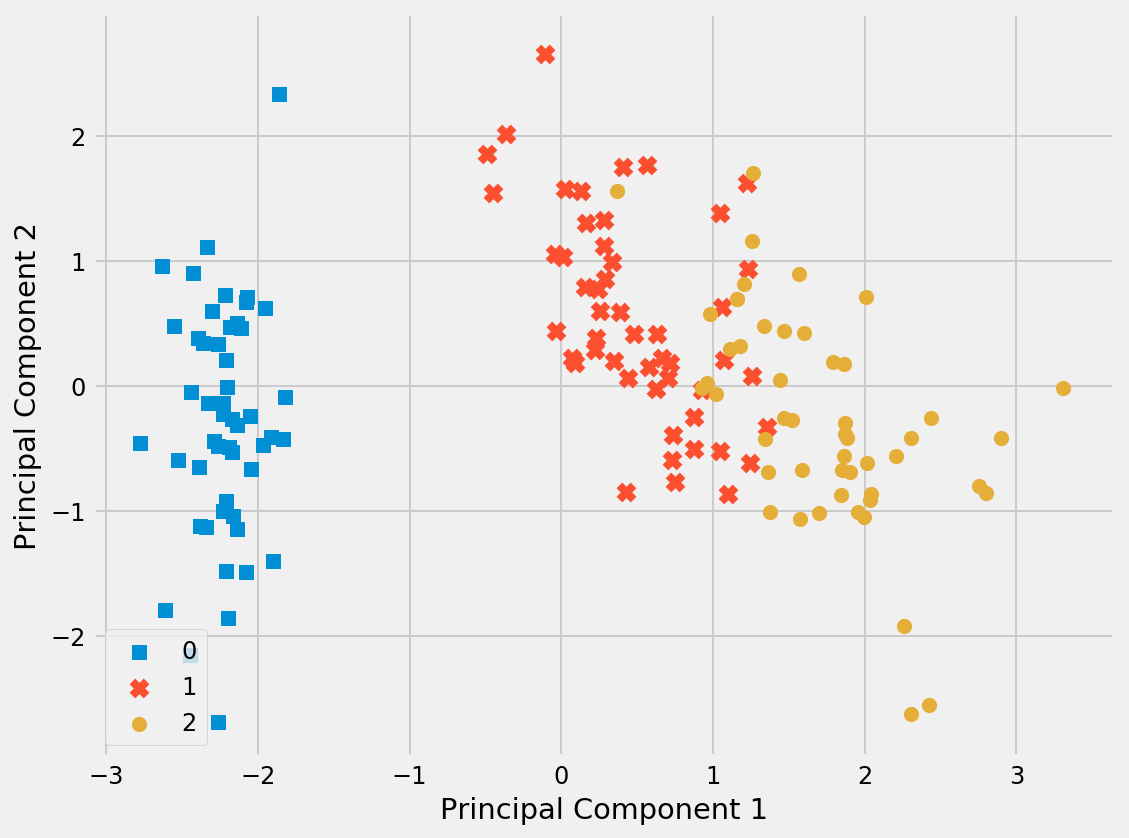

In [12]:
X_std_pca = X_std.dot(eig_vecs[:, 0:2])
plot_iris_pca(X_std_pca, y)

As we've now understood the components separately let's put them all together in a single class, train it and confirm the result with scikit-learn's PCA model by printing out the explained variance ratio:

In [13]:
class PCAModel:
    """
    Principal Component Analysis (PCA)
    
    Parameters
    ----------
    n_components : int
    top number of principal components to keep
    """

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # standardize
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X = (X - self.mean) / self.scale
        
        # eigen decomposition
        eig_vals, eig_vecs = np.linalg.eig(np.cov(X.T))
        self.components = eig_vecs[:, :self.n_components]
        var_exp = eig_vals / np.sum(eig_vals)
        self.explained_variance_ratio = var_exp[:self.n_components]
        return self

    def transform(self, X):
        X = X.copy()
        X = (X - self.mean) / self.scale
        X_pca = X @ self.components
        return X_pca

In [14]:
# Implementation from Scratch
pca_model = PCAModel(n_components = 2).fit(X)

# Using library to confirm results
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components = 2).fit(X_std)

# Printing explained ratio to see if it matches
print(' Results from library: ', pca.explained_variance_ratio_)
print('\n Results from scratch: ', pca_model.explained_variance_ratio)

 Results from library:  [0.72962445 0.22850762]

 Results from scratch:  [0.72962445 0.22850762]


## 3.3 Takeaways

Okay, that was quite a lot right? Let's quickly wrap things up with a summary of PCA and some of it's crucial applications. For the identification of underlying patterns existing in our data, we often look for variation across observations to distinguish them from one another. Hence it seems reasonable to be able to find a succinct representation that best captures the variation in our initial raw data. PCA, in particular looks to explain our data via it's maximum directions of variance. By compressing a higher dimensional dataset into a lower one, while still retaining most of the variance(information) allows us to:

- **Perform Visualization**: PCA summarizes our data along the principal components(eigen vectors), which explains most of the variance. Thus we can reduce the dataset to fewer dimensions and can visualize our data's distribution. This is pretty helpful when we're performing clustering algorithm that requires number of clusters to  be defined beforehand. 


- **Speed up Machine Learning Algorithms**: When dealing with Big Data, we might want to decompose the features into a lower dimension, without a significant loss in variance. By performing dimensionality reduction methods, we can reduce the amount of features to work with. It eventually speeds up the training algorithm and saves our memory. For this coming part, I'll use the Iris dataset again and show that by keeping the data's top 3 principal components; we can obtain the same level of accuracy as keeping all 4 features:

In [15]:
# Splitting 30% of the Iris data into a test set for evaluation
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3, random_state = 1)

# Creating a  pipeline, where we'll standardize the data, perform PCA and fit the logistic regression
pipeline1 = Pipeline([
    ('standardize', StandardScaler()),
    ('pca', PCA(n_components = 3)),
    ('logistic', LogisticRegression(random_state = 1))
])
pipeline1.fit(X_train, y_train)
y_pred1 = pipeline1.predict(X_test)

# Pipeline without PCA
pipeline2 = Pipeline([
    ('standardize', StandardScaler()),
    ('logistic', LogisticRegression(random_state = 1))
])
pipeline2.fit(X_train, y_train)
y_pred2 = pipeline2.predict(X_test)

# Check out the prediction accuracy
print('PCA Accuracy: %.3f' % accuracy_score(y_test, y_pred1))
print('\n Without PCA Accuracy: %.3f' % accuracy_score(y_test, y_pred2))

PCA Accuracy: 0.822

 Without PCA Accuracy: 0.822


C:\Users\This PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\This PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\This PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\This PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


---

# 4. Singular Value Decomposition (SVD)

In [16]:
# Importing Libraries and Modules
# For data analysis
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt

# Packages from Sklearn
from scipy.linalg import svd as scipy_svd
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Magic functions from Jupyter
# For inline plot
%matplotlib inline

#For printing versions
%reload_ext watermark

# For  making the notebook reload external python modules
%reload_ext autoreload
%autoreload 2

# For enabling retina(high resolution) plots
%config InlineBackend.figure_format = 'retina'

%watermark -p sklearn
%watermark -v -m --iversions

sklearn 0.21.2
matplotlib 3.1.1
pandas     0.25.1
numpy      1.16.4
CPython 3.7.3
IPython 7.8.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit


## 4.1 Introduction to SVD

Whenever we start a Data Analysis Project, it's very common to encounter dataset that contains some useful information to the task at hand, but may also contain some information of low quality that do not contribute too much to the end objective. When you're facing this issue, there are numerous way of isolating the signal from the noise. Say, for example, we can employ *regularization* methods such as **Lasso Regression** to perform constrained optimization, automatically dropping uninformative features from the model or use **Tree Based Methods** to identify the features that were most often used for constructing the tree.

Or we can use a method which maximizes the Variance such as **Principal Component Analysis (PCA)** (studied above) that aims to transform the data into a new set of orthogonal components, ensuring that the first component aligns to the maximum variance in the dataset, and the subsequent component aligns with the next maximum component and so on. It can be put this way, it makes a dataset more compact while preserving information. The conventional method (the one above) for calculating PCA requires us to compute the full covariance matrix, making it suffer from extensive use of memory & can be numerically unstable. It turns out that, **SVD** is a method that can be used to compute PCA and obtain the principal components(directions) to transform our raw dataset.

**Singular Value Decompositon (SVD)** is a specific decomposition technique that decomposes an arbitrary matrix $A$ with $m$ rows and $n$ columns(assuming the matrix also has a rank of $r$ i.e. $r$ columns of the matrix $A$ are linearly independent) into a set of related matrices:

$$A = U\Sigma V^T$$

where:

- $\Sigma$ (Sigma) is a $r * r $ non-negative, decreasing order diagonal matrix. All elements not on the main diagonal are 0 and the elements of $\Sigma$ are called the singular values. Another general notation that is used in place for this matrix is $S$. Thus in the following discussion, we'll use them inter-changeably.

- $U$ is a $m * r $ orthonormal matrix and $V$ is a $n * r $ orthonormal matrix.
    - Orthogonal matrix refers to a square matrix where the columns are 90 degrees between each other and it's inner dot product is zero i.e. Given an orthogonal matrix $Q$, $Q^TQ = QQ^T = I$ and $Q^T = Q^{-1}$.
    
    - In case you're wondering what an orthonormal matrix is : it's an orthogonal matrix where columns are unit vectors.

Okay too much of notations, let's visualize it for better understanding. A classic pictorial representation of SVD:

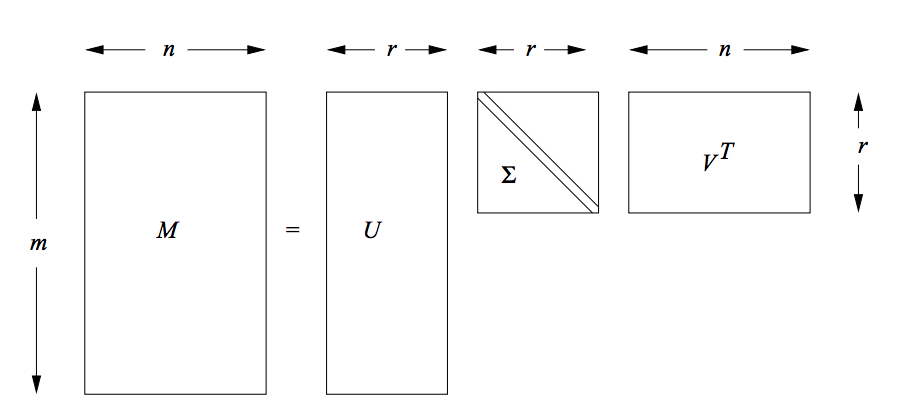

# 4.2 Interpretation of SVD

### 4.2.1 Geometric Interpretation

For ease of visualization, for the geometric interpretation, we'll use a 2-dimensional dataset. Transformation of a matrix by $U\Sigma V^T$ can be visualized as a rotation and reflection, scaling, rotation and reflection. We'll see this a step-by-step visualization for better understanding:

Given a matrix $x = \begin{bmatrix} -10 & -10 & 20 & 20\\ -10 & 20 & 20 & -10 \end{bmatrix}$ and a transformation matrix $A = \begin{bmatrix} 1 & 0.3 \\ 0.45 & 1.2 \end{bmatrix}$.

- $V^Tx$: We can see that multiplying by $V^T$ rotates and reflects the input matrix $x$. Notice, the swap of colors red-blue and green-yellow indicating a reflection along x-axis.

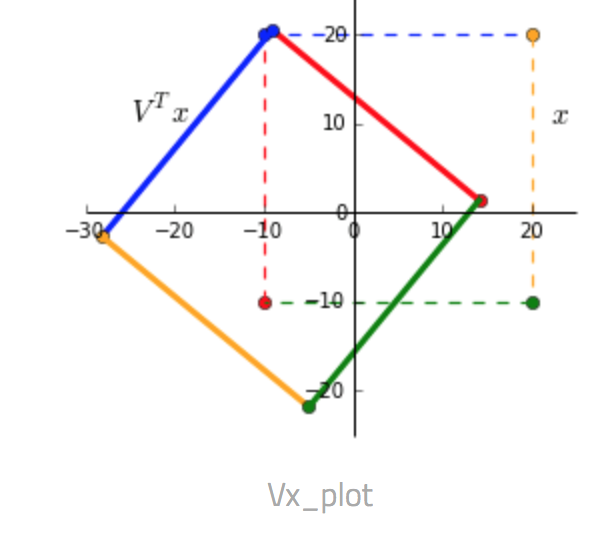

- $SV^Tx$ : Since $S$ only contains values on the diagonal, it scales the matrix $V$ rotates the matrix to a position where the singular values now represent the scaling factor along the $V$-basis. In the picture given below, $V^Tx$ is dashed and $SV^Tx$ is solid.

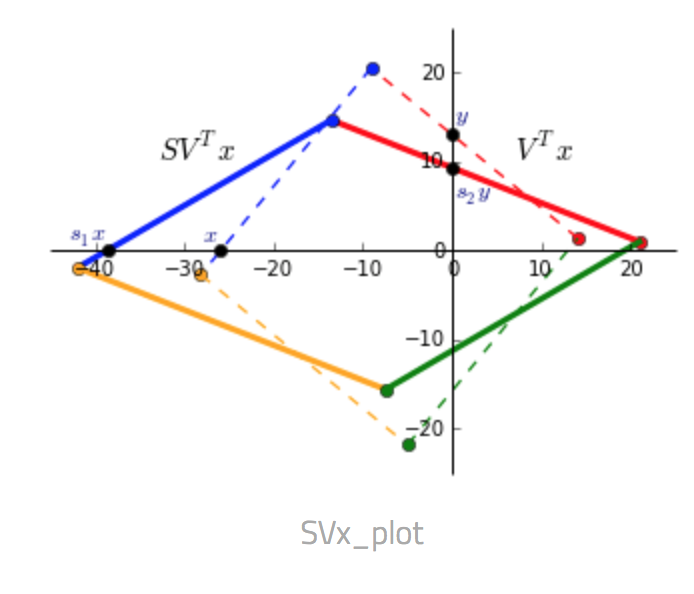

- $USV^T$: Finally, $U$ rotates and reflects the matrix back to the standard basis.

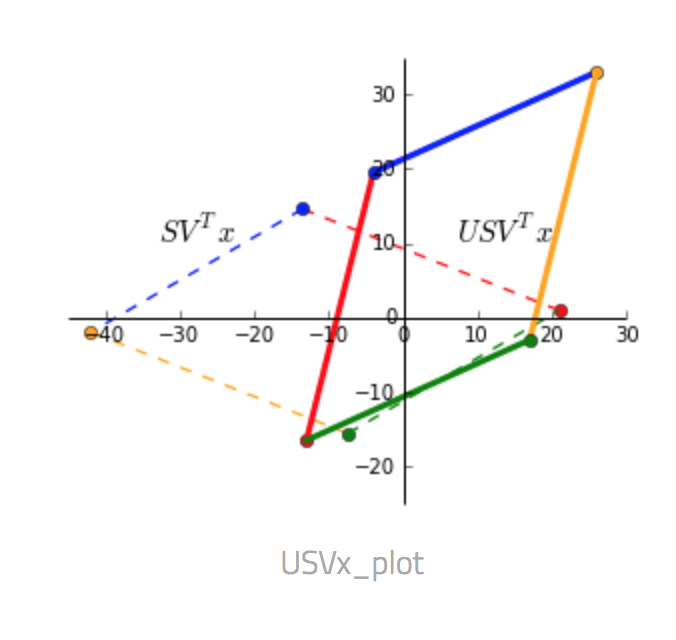

Combining all three steps into one picture below, the dashed square shows $x$ as the corners and the transformed matrix. $Ax$ as the solid shape.

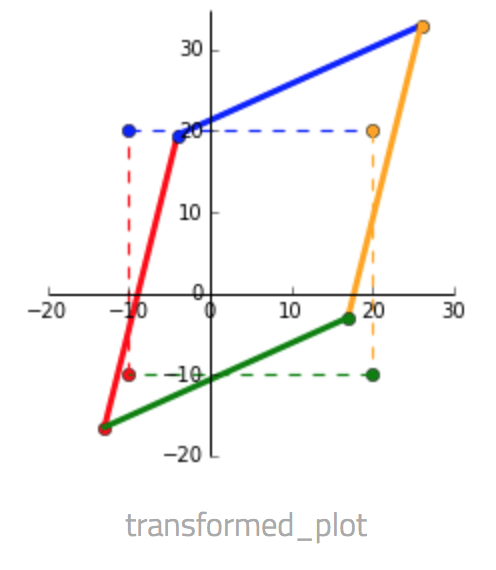

The most crucial and useful property of the SVD is that the axes in the new space, which represents new latent attributes, are orthogonal. Hence, original attributes are expressed in terms of new attributes that are independent of each other. Let's confirm this with code:

In [17]:
A = np.array([[1, 0.3], [0.45, 1.2]])
U, S, V = scipy_svd(A)
print('Singular Values:', S)

# the example 2d matrix
x = np.array([[-10, -10, 20, 20], [-10, 20, 20, -10]]).T
x

Singular Values: [1.49065822 0.71444949]


array([[-10, -10],
       [-10,  20],
       [ 20,  20],
       [ 20, -10]])

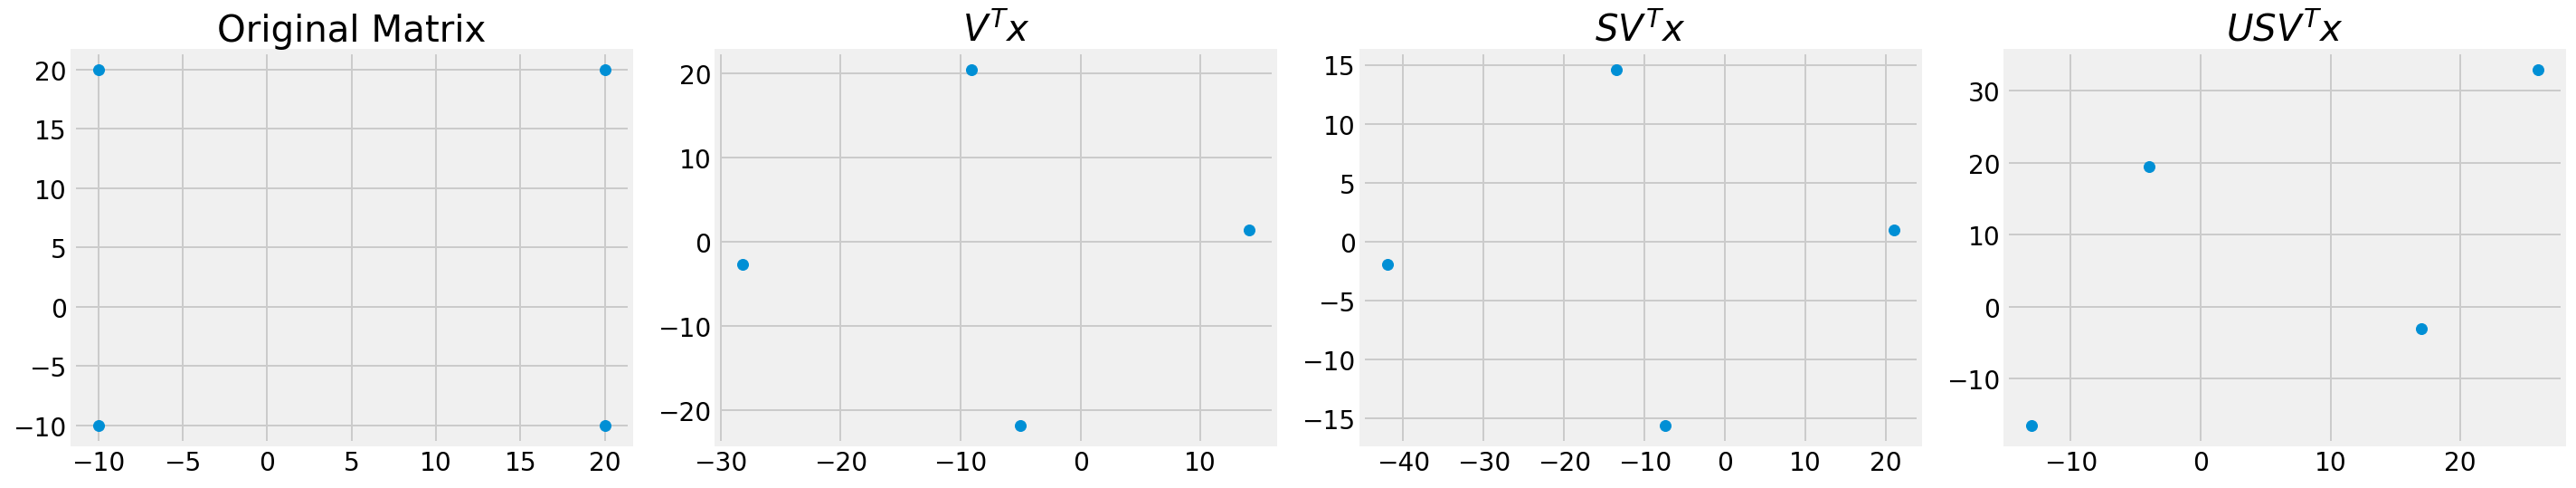

In [18]:
# Changing default font size 14
plt.rcParams['font.size'] = 14

# Plot isn't pleasing to eyes as the ones above, but does the job
fig, ax = plt.subplots(1, 4, figsize = (20, 4))

ax[0].scatter(x[:, 0], x[:, 1])
ax[0].set_title('Original Matrix')

temp = x @ V.T
ax[1].scatter(temp[:, 0], temp[:, 1])
ax[1].set_title('$V^Tx$')

temp = temp @ np.diag(S)
ax[2].scatter(temp[:, 0], temp[:, 1])
ax[2].set_title('$SV^Tx$')

temp = temp @ U
ax[3].scatter(temp[:, 0], temp[:, 1])
ax[3].set_title('$USV^Tx$')

plt.tight_layout()
plt.show()

### 4.2.2 Factor Interpretation

Here we're given a rank 3 matrix $A$, representing ratings of movies by users:

| Name       | Matrix       | Alien  | Star Wars | Casablanca | Titanic |
| -------------: |-------------:| ---------:|--------------:|---------------:|----------:|
| Joe      | 1 | 1 | 1 | 0 | 0 |
| Jim      |  3 | 3 | 3 | 0 | 0 |
| John | 4 | 4 | 4 | 0 | 0 |
| Jack | 5| 5 | 5|  0|  0 |
| Jill | 0 | 2 | 0 | 4 | 4 |
| Jenny |0 | 0 | 0 | 5 | 5 |
| Jane | 0 | 1 | 0  | 2 | 2 |

Applying SVD to this matrix will give us the following decomposition:

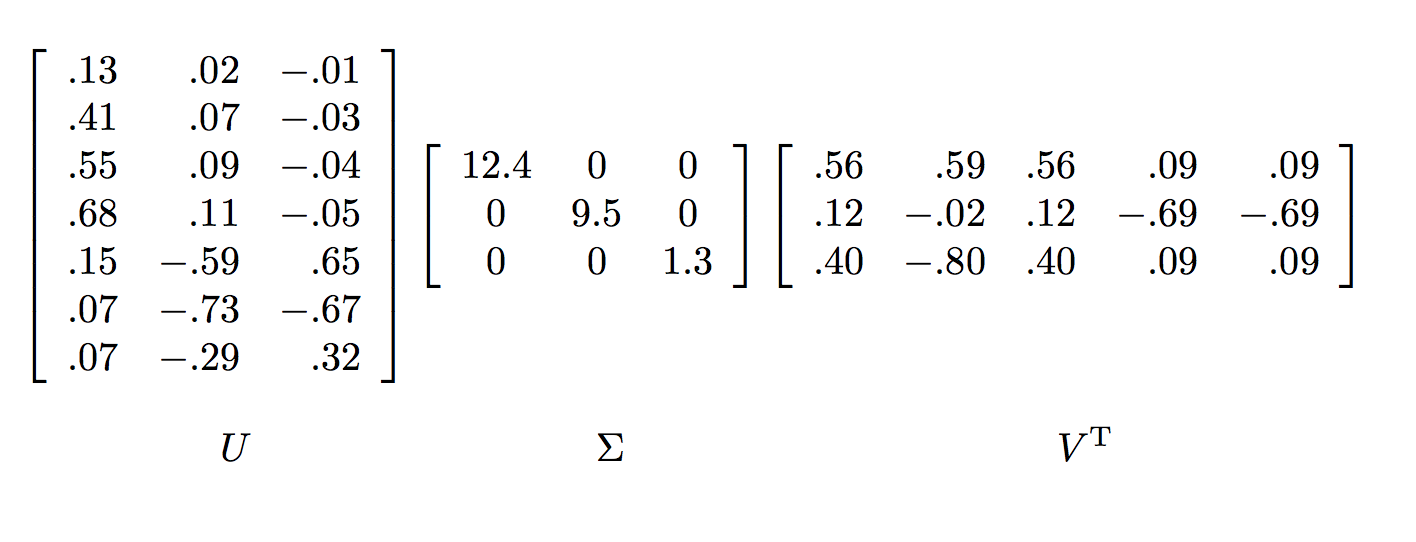

The key to understanding what SVD offers is viewing the $r$ columns of $U$, $\Sigma$ and $V$ as representing concepts that are hidden in the original matrix. In our contrived example, we can imagine there are two concepts underlying the movies, scientific fiction and romance.

To be explicit:

- The matrix $U$ connects people to concept. For example, looking at Joe (the first row in original matrix). The value 0.13 in the first row and first column of $U$ is smaller than some of the other entries in that column. The rationale for this is because while Joe watches only science-fiction, he doesn't rate those movies highly.


- The matrix $V$ relates movies to concept. The approximately 0.58 in each of the first three columns of the first row of $V^T$ indicates that the first three movies - The Matrix, Alien and Star Wars - each are of science-fiction genre.


- Matrix $\Sigma$ gives the strength of each concepts. In our example, the strength of the science-fiction concept is 12.4, while the strength of the romance concept is 9.5. Intuitively, the science-fiction concept is stronger because the data provides more information about the movies of that genre and the people who like them.


- The third concept is a bit harder to interpret, but it doesn't matter that much, because it's weight, given by the third non-zero diagonal entry $\Sigma$ is relatively low compared to the first two concepts.


- The thing to note here is that the matrix decomposition doesn't know the meaning of any column in the dataset, it discovers the underlying concept and it's us to interpret these latent factors.

## 4.3 Full SVD Worked Example

Let's step in through a worked example of "Full" SVD. In practice, the full version is computionally expensive, as we must calculate the full matrices $U_{mr}$, $S_{rr}$ and $V^T_{nr}$. The "truncated" versions of SVD are usually preferred, where we can preselect the $ k < r $ dimensions of interest and calculate $U_{mk}$, $S_{kk}$ and $V^T_{nk}$. But the truncated version is a topic that we'll we covering some other day.

In [19]:
# Matrix form of the table we had above

rank = 3
A = np.array([
    [1, 1, 1, 0, 0],
    [3, 3, 3, 0, 0],
    [4, 4, 4, 0, 0],
    [5, 5, 5, 0, 0],
    [0, 2, 0, 4, 4],
    [0, 0, 0, 5, 5],
    [0, 1, 0, 2, 2]])

# Making use of Scipy's SVD to confirm our results with it
U, S, V = scipy_svd(A, full_matrices = False)

# Just printing out S, a.k.a Sigma to show the numbers are identical to the results shown earlier
print(S)

[1.24810147e+01 9.50861406e+00 1.34555971e+00 1.84716760e-16
 9.74452038e-33]


In [20]:
# For verifcation of some properties of SVD

# Verifying calculation of A = USV^T
print(np.allclose(A, U @ np.diag(S) @ V))

# Orthonormal, columns are unit vectors (length = 1 )
print(np.allclose(np.round(np.sum(U * U, axis = 0)), np.ones(S.size)))

# Orthogonal, dot product of itself is equivalent to the identity matrix U^T U = I
print(np.allclose(U.T @ U, np.eye(S.size)))

True
True
True


The SVD of a matrix $A$ is strongly connected to the eigen values of the symmetric matrices $A^TA$ and $AA^T$. We'll start with the expression for SVD: $A = U\Sigma V^T$ .

\begin{align}
A^T
&= (U \Sigma V^T)^T \\
&= (V^T)^T \Sigma^T U^T \\
&= V \Sigma^T U^T \\
&= V \Sigma U^T
\end{align}

In the above derivation, we used the matrix property that $(BA)^T = A^TB^T$ and in the final step $\Sigma$ is a diagonal matrix, thus $\Sigma ^T = \Sigma$. Moving on:

\begin{align}
A^T A
&= (V \Sigma U^T)(U \Sigma V^T)  \\
&= V \Sigma I \Sigma V^T \\
&= V \Sigma \Sigma V^T
\end{align}

In the second step, we use the fact that $U$ is a orthonormal matrix, so $U^TU$ is an identity matrix of the appropriate size. We now multiply both sides of this equation by V to get:

\begin{align}
A^T A V
&= V \Sigma^2 V^T V \\
&= V \Sigma^2 I \\
&= V \Sigma^2
\end{align}

Here we use the fact that $V$ is also an orthornormal matrix, so $V^TV$ is an identity matrix of the appropriate size. Looking at the equation $A^TAV = V\Sigma ^2$, we now see that V is the eigen vector of the matrix $A^TA$ and $\Sigma^2$ is the diagonal matrix whose entries are the corresponding eigen values i.e. $V = eig(A^TA)$ .

In [21]:
AtA = A.T @ A
_, V1 = np.linalg.eig(AtA)
    
    # Notable that the possible non-uniqueness of the decomposition means that an axis can be flipped 
    # without changing anything fundamental, thus we compare whether the absolute values are relatively 
    # instead of the raw values
    
print(np.allclose(np.abs(V1[:, :rank]), np.abs(V1[:,  :rank])))

True


Only $U$ remains to be computed, but it can be found in the same way we found in the same way we found $V$. Instead this time, we'll be starting with $AA^T$:

\begin{align}
A A^T U
&= (U \Sigma V^T)(V \Sigma U^T) U \\
&= V \Sigma I \Sigma V^T U \\
&= U \Sigma \Sigma U^T U \\
&= U \Sigma \Sigma I \\
&= U \Sigma^2
\end{align}

In other words: $U = eig(AA^T)$

In [22]:
AAt = A @ A.T
_,  U1 = np.linalg.eig(AAt)
np.allclose(np.abs(U1[:, :rank]), np.abs(U[:, :rank]))

True

In [23]:
# Notable thing since this is a rank of 3 matrix only the first 3 values of 3 contains non-zero values
np.round(S, 0)

array([12., 10.,  1.,  0.,  0.])

To summarize this section up:

- $U$ is a $m*r$ orthonormal matrix of "left singular"(eigen) vectors of $AA^T$.
- $V$ is a $n*r$ orthonormal matrix of "right-singular" (eigen) vectors of $A^TA$
- $\Sigma$ is a $r*r$ non-negative, decreasing order diagonal matrix. All elements not on the main diagonal are 0 and the elements of $\Sigma$ are called the singular values, which is the square root of non-zero  eigen values.

For those interested, you can check out a detail walkthrough of the computation by hand!

## 4.4 Relationships with PCA

Usage of SVD is quite similar to Principal Component Analysis(PCA) and you'd be amazed how several numerical software libraries actually use SVD under the hood for their PCA routines, say for example: ```python sklearn.decompositon.PCA ``` within scikit-learn. This is due to the reason that it's more numerically stable and it's also possible to perform a truncated SVD, which only needs us to calculate $U\Sigma V^T$ for the first $k<n$ features, this makes it far faster than to compute than full co-variance matrix as computed within PCA.


In the incoming section, we'll take a look at the relationship between these two methods, i.e. PCA and SVD. Let's recall from the discussion we had about PCA, given the input matrix $X$:the math behind the algorithm is to solve the eigen-decomposition for the correlation matrix(assuming that we've already standardized all features) $C = X^TX/(n-1)$. It turns out that, we can represent $C$ by a product of its eigen vectors $W$ and diagonalized eigen values $L$.


\begin{align}
\mathbf C &= \mathbf W \mathbf L \mathbf W^T
\end{align}

In [24]:
# Using an example dataset for explanation
iris = load_iris()
X = iris['data']

# Creating the Pipeline
standardize = StandardScaler()
pca = PCA()
pipeline = Pipeline([
    ('standardize', standardize),
    ('pca', pca)
])

X_pca = pipeline.fit_transform(X)

In [25]:
standardize = pipeline.named_steps['standardize']
X_std = standardize.transform(X)

# Confirm the WLW^T
X_cov = np.cov(X_std.T)
eigen_values, eigen_vecs = np.linalg.eig(X_cov)
reconstructed_X = eigen_vecs @ np.diag(eigen_values) @ np.linalg.inv(eigen_vecs)
print(np.allclose(X_cov, reconstructed_X))

True


Once we've obtained the eigen vectors, i.e. principal components/directions, we can project our raw data samples onto the principal axes, which are called Principal Component Scores via the operation $XW$.

As for singular decomposition, $X = U\Sigma V^T$. We can work out the correlation matrix using this form:

\begin{align}
\mathbf C
&= \mathbf V \mathbf \Sigma \mathbf U^T \mathbf U \mathbf \Sigma \mathbf V^T / (n - 1) \\
&= \mathbf V \frac{\mathbf \Sigma^2}{n - 1}\mathbf V^T
\end{align}

What it implies? Right singular vectors $V$ are principal directions or components and Singular Values are related to the eigen values of correlation matrix via $L = \Sigma ^2 / (n-1)$. And the Principal Component scores can be computed by : $XV = U\Sigma V^TV = U\Sigma$.

In [26]:
# We'll print out the Eigen Vectors learned from PCA and the V learned from SVD
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

In [27]:
# We can do  X @ V to obtain the Principal Compnents Score
U, S, V = scipy_svd(X_std)
V

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [-0.37741762, -0.92329566, -0.02449161, -0.06694199],
       [ 0.71956635, -0.24438178, -0.14212637, -0.63427274],
       [ 0.26128628, -0.12350962, -0.80144925,  0.52359713]])

The thing to note here is that some of the signs are flipped(positive turned to negative & vice-versa), this is normal due to the previously stated non-uniqueness of the decomposition. We'll now wrap up this section with a diagram of PCA vs SVD:

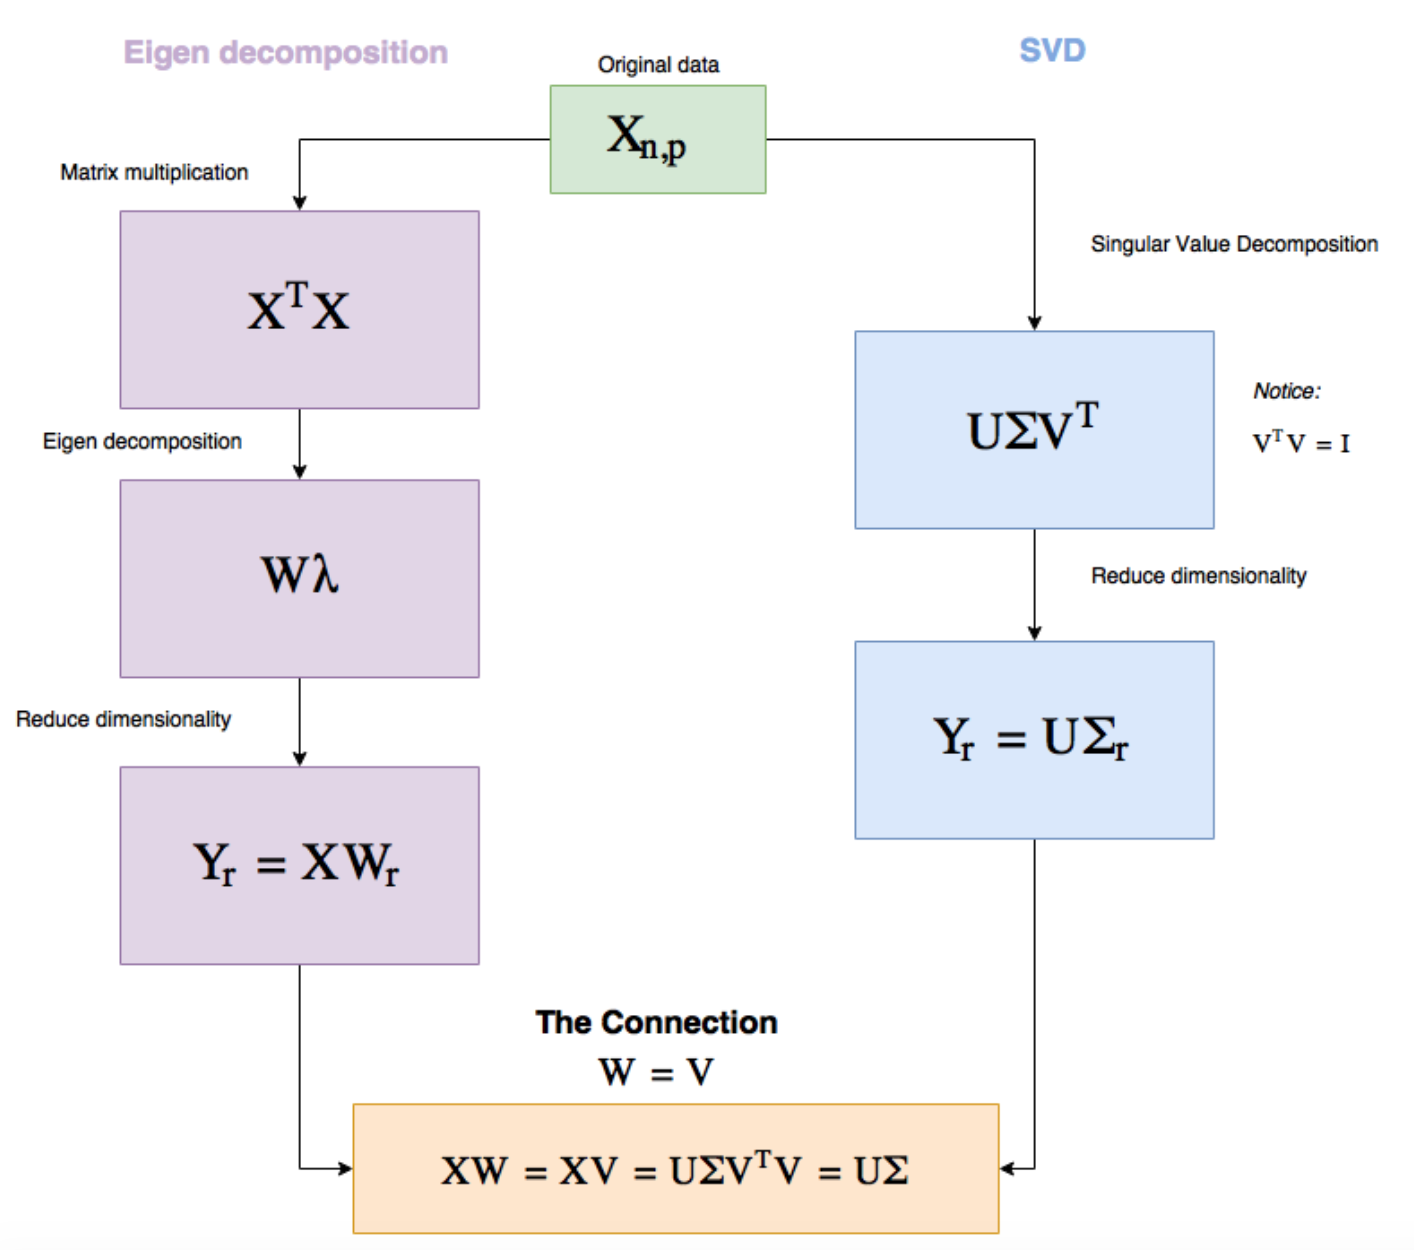

## 4.5 Applications

SVD has a wide array of applications and the list down below doesn't mean to serve as an exhaustive resource for all of them. 

### 4.5.1 Dimensionality Reduction

As SVD are PCA are quite closely related to each other, similar to PCA, we can imagine very frequent usage of SVD in Feature Reduction.By only choosing the top $k$ singular values, we've in effect compressed the original information and represented it using fewer features. Nte that because SVD is also a numerical algorithm similar to PCA, it's crucial to standardize the features to make sure that the magnitude of the entries are of similar range.

### 4.5.2 Information Retrieval

One of the most crucial and widely used application domain of SVD is **Information Retrieval**, in this particular application, it's also commonly referred as **Latent Semantic Analysis(LSA)** or **Latent Semantic Indexing?(LSI)**. As we'll see soon, the idea is quite similar to *Topic Modeling*. Okay, now what all of this fuss about? So, in simple terms, the fundamental problem to solve in Information Retrieval is : you're given some search terms, your task is to retrieve all of the documents that contain those search terms or, perhaps more usefully, return those documents whose content is semantically related to the search terms. Let's understand it this way. Say, for example, if one of the search terms was *"automobile"*  it might be appropriate to return all such documents that contain the search term *"car"*.

There might be several feasible approaches to the problem. One of them could go this way: Given an information repository, we might convert a raw text to document-term matrix with one row per document and one column per search term or word. Later, convert the search term as a vector in the same space, and retrieving document vectors that are close to search vector. There are several issues with vector-based retrieval.  Let's list some of them out:

- First, the space is quite high dimensional. For example, a typical collection of documents can easily contain more than 100,000 words even if *Stemming* is applied(i.e. "skip", "skipping", "skipped" all are treated as the same word). Now this creates the issue as distance measurement becomes difficult as number of dimensions tend to increase popularly known as *Curse of Dimensionality*.


- Second, this approach treats each word as independent, contrarily in Languages like English, the same word can have two different meanings altogether("bear" have two meanings; a burden and an animal), and two different words can mean the same thing("car" and "automobile").

**Question: How does SVD helps us here?**

By applying SVD, we can reduce the number of dimensions to speed up the search as words having similar meanings will be mapped to a similar truncated space. Wanna see an example just quick? Say no more!

In [28]:
example = [
    'Machine Learning is awesome',
    'I am in love with Python',
    'Statistics and Probability drive me crazy',
    'Neural Nets are cool shit',
    'NLP is cool, too',
    'GANs are awesome to work with'
]

# A two-staged Model Pipeline. First convert raw worsds to a tf-idf document-search term/word matrix. Later apply SVD decomposition to it.
tfidf = TfidfVectorizer(stop_words = 'english')
svd = TruncatedSVD(n_components = 2)
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('svd', svd)
    ])

X_lsa = pipeline.fit_transform(example)
X_lsa

array([[-0.00000000e+00,  7.91080151e-01],
       [ 3.43575952e-16,  0.00000000e+00],
       [ 4.03267417e-15, -3.49054415e-16],
       [ 7.97285148e-01, -1.74527208e-16],
       [ 7.97285148e-01, -6.98108830e-16],
       [ 8.79480735e-16,  7.91080151e-01]])

In [29]:
# Mapping of words to Latent Factors/Concepts i.e. each concept is a linear combination of words
tfidf = pipeline.named_steps['tfidf']
vocab = tfidf.get_feature_names()
pd.DataFrame(svd.components_, index = ['concept1', ' concept2'], columns = vocab)

,awesome,cool,crazy,drive,gans,learning,love,machine,nets,neural,nlp,probability,python,shit,statistics,work
concept1,3.714474e-16,6.660032e-01,1.425155e-15,1.389748e-15,7.378153e-16,-1.949303e-16,1.505578e-16,-1.948028e-16,3.272502e-01,3.272502e-01,4.849346e-01,1.442309e-15,1.505578e-16,3.272502e-01,1.442309e-15,7.365259e-16
concept2,6.340862e-01,-5.859226e-16,-2.280548e-16,-1.540264e-16,3.866312e-01,3.866312e-01,-4.202165e-17,3.866312e-01,-1.362307e-16,-1.362307e-16,-5.398925e-16,-2.198804e-16,-4.202165e-17,-1.362307e-16,-2.198804e-16,3.866312e-01


In [30]:
svd = pipeline.named_steps['svd']
print('Total Variance Explained:', np.sum(svd.explained_variance_))

# Mapping of document to latent factors/concepts i.e. Each Document is a linear combination of the concepts
pd.DataFrame(X_lsa, index = example, columns = ['concept1', 'concept2'])

Total Variance Explained: 0.2803269804933868


,concept1,concept2
Machine Learning is awesome,-0.000000e+00,7.910802e-01
I am in love with Python,3.435760e-16,0.000000e+00
Statistics and Probability drive me crazy,4.032674e-15,-3.490544e-16
Neural Nets are cool shit,7.972851e-01,-1.745272e-16
"NLP is cool, too",7.972851e-01,-6.981088e-16
GANs are awesome to work with,8.794807e-16,7.910802e-01


Once we're done applying LSA, we can use the compressed features to see which documents are more similar to a particular document. The following code snippet shows that the pair-wise cosine similarity of all the documents.

In [31]:
X_normed = normalize(X_lsa, axis = 1)
similarity = X_normed @ X_normed.T
pd.DataFrame(similarity, index = example, columns = example)

,Machine Learning is awesome,I am in love with Python,Statistics and Probability drive me crazy,Neural Nets are cool shit,"NLP is cool, too",GANs are awesome to work with
Machine Learning is awesome,1.000000e+00,0.000000e+00,-0.086234,-2.189019e-16,-8.756075e-16,1.000000e+00
I am in love with Python,0.000000e+00,1.000000e+00,0.996275,1.000000e+00,1.000000e+00,1.111747e-15
Statistics and Probability drive me crazy,-8.623413e-02,9.962749e-01,1.000000,9.962749e-01,9.962749e-01,-8.623413e-02
Neural Nets are cool shit,-2.189019e-16,1.000000e+00,0.996275,1.000000e+00,1.000000e+00,8.928448e-16
"NLP is cool, too",-8.756075e-16,1.000000e+00,0.996275,1.000000e+00,1.000000e+00,2.361392e-16
GANs are awesome to work with,1.000000e+00,1.111747e-15,-0.086234,8.928448e-16,2.361392e-16,1.000000e+00


### 4.5.3 Collaborative Filtering

SVD can also be applied to implementing *Recommendation Systems*, namely Collaborative Filtering. You may refer to understand it with my tutorial:

---

# 5 References & Acknowledgements

- [Youtube: Dimensionality Reduction](https://www.youtube.com/playlist?list=PLnnr1O8OWc6aVexn2BY0qjklobY6TUEIy)

- [Youtube: PCA Step by Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

- [Notebook: Dimensionality Reduction](http://ethen8181.github.io/machine-learning/dim_reduct/)

- [Blog: Principal Component Analysis 4 Dummies](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/)

- [Blog: What are Eigenvectors and Eigenvalues?](http://www.visiondummy.com/2014/03/eigenvalues-eigenvectors/)

- [Blog: Principal Component Analysis in 3 simple steps](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

- [Blog: Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)

- [Notebook: In Depth: Principal Component Analysis](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/95664b978439df948b2cd2f5f5b4e31f28b30394/notebooks/05.09-Principal-Component-Analysis.ipynb)

- [StackExchange: What is an intuitive explanation for how PCA turns from a geometric problem (with distances) to a linear algebra problem (with eigenvectors)?](http://stats.stackexchange.com/questions/217995/what-is-an-intuitive-explanation-for-how-pca-turns-from-a-geometric-problem-wit)

- [StackExchange: Making sense of principal component analysis, eigenvectors & eigenvalues](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)




- [Notes: Latent Semantic Analysis](http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf)

- [Notes: Singular Value Decomposition Tutorial](https://datajobs.com/data-science-repo/SVD-Tutorial-[Kirk-Baker].pdf)

- [Blog: Feature Reduction using SVD](http://blog.applied.ai/feature-reduction-using-svd/)

- [Blog: Singular Value Decomposition Demystified](http://makeyourowntextminingtoolkit.blogspot.co.uk/2017/02/singular-value-decomposition-demystified.html)

- [Blog: Singular Value Decomposition (SVD) Visualisation](https://alyssaq.github.io/2015/singular-value-decomposition-visualisation/)

- [Blog: Reducing Dimensionality from Dimensionality Reduction Techniques](https://towardsdatascience.com/reducing-dimensionality-from-dimensionality-reduction-techniques-f658aec24dfe)

- [Online book: Mining Massive Dataset: Chapter 11 Dimensionality Reduction](http://infolab.stanford.edu/~ullman/mmds/ch11.pdf)

- [Online book: Understanding Complex Datasets - Data Mining with Matrix Decomposition Chapter 3: Singular Value Decomposition (SVD)](http://lnfm1.sai.msu.ru/~rastor/Books/Skillicorn-Understanding_complex_datasets_data_mining_with_matrix_decompositions.pdf)

- [StackExchange: Relationship between SVD and PCA. How to use SVD to perform PCA?](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

---